In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizerFast, DataCollatorForLanguageModeling
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append("../VAE_standard")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE

from matplotlib import pyplot as plt

sys.path.append("..")
import utils

from Bio import SeqIO
from Bio.Seq import Seq

from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

from ex2_hamming_vs_influence import get_ex2_data
import pickle
import pandas as pd
import scipy

In [2]:
MAX_TOKEN_LENGTH = 510
BATCH_SIZE=60
BIF_BATCH_SIZE=80
num_masks = 3

TEST_SEQ = 1
# TRAIN_CUTOFF = 3000
# TEST_TOKEN = 0

DEVICE = "cuda"

In [3]:
"""
tokenizer: 
input_ids - torch.LongTensor of shape (batch_size, sequence_length)
attention_mask - torch.Tensor of shape (batch_size, sequence_length), Mask values selected in {0,1}, where 0 := masked, 1 := not masked
"""

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="pt")

model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(DEVICE)

In [4]:
data = get_ex2_data(tokenizer)
aa_drop_na = data["aa_drop_na"]
names_drop_na = data["names_drop_na"]
unique_aa_seqs = data["unique_aa_seqs"]
train_data = data["train_data"]
bif_data = data["bif_data"]

num_obs = len(bif_data)
num_data = len(bif_data)
with open("ex2_computed_influences.pkl", "rb") as file:
    computed_bif_matrix, _ = pickle.load(file)
hamming_dist = torch.sum(((bif_data[None,:,:] - bif_data[:,None,:]) != 0), dim=-1).numpy()

done extracting sequences!
done extracting AAs!


In [5]:
def get_density_and_distr(bif_matrix, n_bins=1000):
    """
    returns discretized density and distribution function of bif_matrix

    inputs:
    bif_matrix (np.array): N x N matrix of pairwise influences among sequences
    n_bins (int): granularity of discretization (the resulting CDF will be an array of length n_bins)
    
    returns:
    xvals: x-values of density/distribution function, i.e. x in F(x) = P(X <= x)
    bif_cdf: cdf y-values (in range [0,1]), i.e. F(x) in F(x) = P(X <= x)
    bif_density: density y-values, i.e. f(x) where f is density function
    """
    
    row, col = np.tril_indices(num_data,k=-1)
    bif_density = computed_bif_matrix[row,col]
    bif_density_y,bif_density_x= np.histogram(bif_density, bins=n_bins, density=True)
    bin_length = bif_density_x[1] - bif_density_x[0]
    xvals = bif_density_x[:-1] + bin_length / 2
    bif_cdf = np.zeros(bif_density_y.shape[0])
    bif_cdf[0] = bif_density_y[0] * bin_length
    for i,d in enumerate(bif_density_y[1:]):
        bif_cdf[i+1] = (bif_cdf[i] + d*bin_length)

    return xvals, bif_cdf, bif_density_y

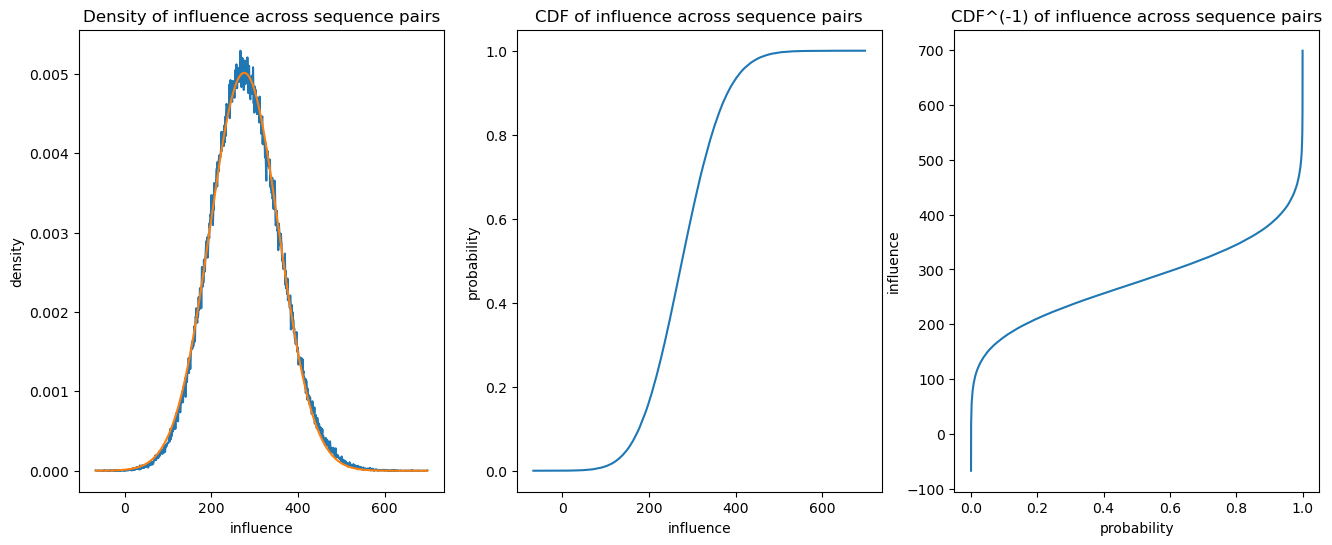

In [6]:
def gaussian(x,mu,var):
    return 1/np.sqrt(2* np.pi * var) * np.exp(-np.square(x-mu) / (2*var)) 

xvals, bif_cdf, bif_density_y = get_density_and_distr(computed_bif_matrix)
(opt_mu, opt_var), pcov = scipy.optimize.curve_fit(gaussian, xvals, bif_density_y, p0=[300, 100])

fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].plot(xvals, bif_density_y)
ax[0].plot(xvals, gaussian(xvals, opt_mu, opt_var))
ax[0].set_title("Density of influence across sequence pairs")
ax[0].set_xlabel("influence")
ax[0].set_ylabel("density")

ax[1].set_title("CDF of influence across sequence pairs")
ax[1].plot(xvals, bif_cdf)
ax[1].set_xlabel("influence")
ax[1].set_ylabel("probability")

ax[2].set_title("CDF^(-1) of influence across sequence pairs")
ax[2].plot(bif_cdf, xvals)
ax[2].set_xlabel("probability")
ax[2].set_ylabel("influence")
plt.show()

In [29]:
def inv_cdf(x, xvals=xvals, cdf_vals=bif_cdf):
    """
    given x and discretized cdf given by (x,y) in (xvals, cdf_vals), return the inverse

    x (np.array): list of values in [0,1] to plug into inverse CDF
    xvals (np.array): CDF x-values, i.e. x in F(x) = P(X <= x)
    cdf_vals (np.array): CDF y-values, i.e. F(x) in F(x) = P(X <= x)
    """

    assert np.all(x <= 1) and np.any(x >= 0), "all elements in inv_cdf x should be in [0,1]"
    
    indices = np.sum(cdf_vals[None, :] <= x[:,None], axis=-1).astype(int)
    return xvals[indices]

def sample_from_distr(N, xvals=xvals, cdf_vals=bif_cdf):
    """
    Independently sample N points from some given distr. 

    N (int): number of points to sample
    xvals (np.array): CDF x-values, i.e. x in F(x) = P(X <= x)
    cdf_vals (np.array): CDF y-values, i.e. F(x) in F(x) = P(X <= x)
    """
    
    rand_uniform = np.random.uniform(low=0,high=1,size=N)
    return inv_cdf(rand_uniform, xvals=xvals, cdf_vals=bif_cdf)

In [8]:
influence_min = inv_cdf(np.array([0.8]))[0]

row, col = np.tril_indices(num_data,k=-1)
intersection_matrix = np.where((bif_data[None,:,:] - bif_data[:,None,:]) != 0, 1, 0)[row,col,:]
# intersection_matrix = torch.where((bif_data[None,:,:] - bif_data[:,None,:]) != 0, 1, 0)

In [40]:
def construct_null(
    n_runs, 
    seq_length = MAX_TOKEN_LENGTH, 
    num_data = len(bif_data), 
    influence_min=influence_min, 
    max_ham_dist=5
):
    null_distr = np.zeros((n_runs, seq_length))
    row, col = np.tril_indices(num_data,k=-1)

    # sample values to get null distr.
    for i in range(n_runs):
        print(".",end="")
        rand_bif_matrix = sample_from_distr(num_data * (num_data - 1) // 2)
        rand_bif_filtered_matrix = rand_bif_matrix >= influence_min
        intersection = np.logical_and((hamming_dist <= max_ham_dist)[row,col], rand_bif_filtered_matrix)
        int_mat = np.sum(intersection_matrix[intersection], axis=0)
    
        null_distr[i,:] = int_mat

    return null_distr

In [10]:
null_distr = construct_null(1000)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [30]:
null_zeros = np.sum(null_distr, axis=0) == 0

null_densities = [np.histogram(null_distr[:,i], bins=100,density=True) for i in range(null_distr.shape[1])]
bin_lengths = np.array([null_densities[i][1][1] - null_densities[i][1][0] for i in range(len(null_densities))])
null_densities_y = np.stack([null_densities[i][0] for i in range(len(null_densities))], axis=0)
null_densities_x = np.stack([null_densities[i][1][:-1] + bin_lengths[i] / 2 for i in range(len(null_densities))], axis=0)

# correct bins to be 0 for any places where density is point mass at 0
null_densities_x[null_zeros] = 0

bif_filtered_matrix = computed_bif_matrix >= influence_min
intersection = np.logical_and(hamming_dist <= 5, bif_filtered_matrix)[row,col]
int_mat_true = np.sum(intersection_matrix[intersection], axis=0)
p_vals = np.sum(np.where((null_densities_x >= int_mat_true[:, None]), null_densities_y , 0), axis=-1) * bin_lengths

### For some fixed $n,k$, Define $A_n:=\{$sequences $(x_i,x_j) : BIF(x_i,x_j) \geq$ top $n\%$ of all influences$\}$ and $B_k := \{$sequences $(x_i,x_j) : ||x_i - x_j||_1 \leq k\}$. I want to see if there's anything interesting going on in $A_n \cap B_k$ 
### That is, are there some specific residues where, if a sequence differs in that residue, the influence of that datapoint is massively changed?

### What I do below is I calculate $A_n$, $B_k$ for $n = 80\%$, $k = 5$ and collect sequences $(x_i, x_j) \in A_n \cap B_k$. Then, I calculate the density of influence across all sequence pairs in the dataset and repeatedly sample from this distribution to create a null distribution for each residue location among sequences $(x_i, x_j) \in A_n \cap B_k$. What I have then is the following distribution(s):

### At each residue location $r$, consider $N_r := $ the number of sequences in $A_n \cap B_k$ that are distinct at residue r. The sampling procedure above gives me a null distribution for each $N_r$, where the null hypothesis is that influence is randomly assigned. I want to find the residues $r$ such that $N_r$ is significantly larger than it would be under random chance

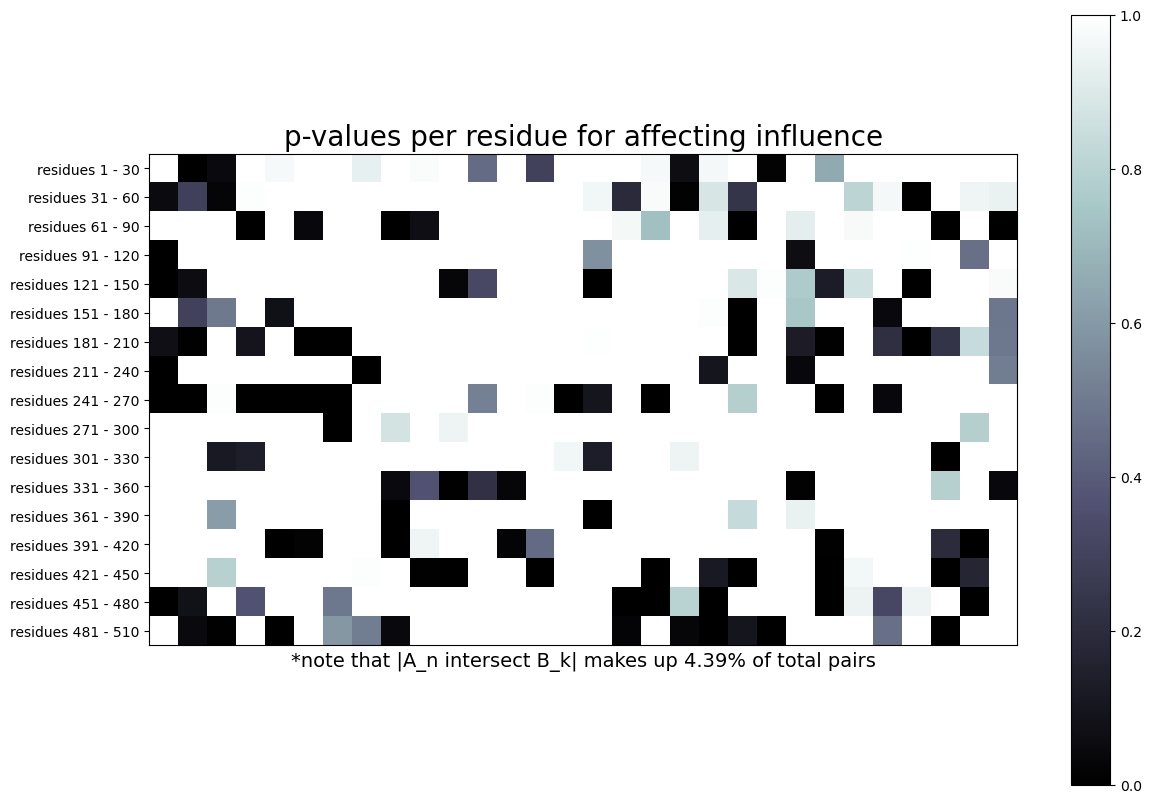

In [57]:
tot_data_pair_prop = np.sum(int_mat_true) / (len(bif_data) * len(bif_data)) * 100

disp_p_vals = p_vals.reshape(17,30)
fig,ax = plt.subplots(1,1,figsize=(14,10))
im = ax.matshow(disp_p_vals, cmap='bone')
plt.title("p-values per residue for affecting influence", fontsize=20)
ax.set_xticks([])
ax.set_xlabel("*note that |A_n intersect B_k| makes up %.2f%% of total pairs"%tot_data_pair_prop, fontsize=14)
ax.set_yticks(np.arange(17))
ax.set_yticklabels(["residues %d - %d"%(i*30+1, (i+1)*30) for i in range(17)])
plt.colorbar(im)
plt.show()